# Import Library

In [12]:
import numpy as np
import pandas as pd
import os
import time
import json
import tensorflow as tf
import random
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD  # Add this import
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback
from IPython import display 

# Pernament random

In [13]:
def set_random_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(42)

# Function

In [14]:
def load_data(csv_file):
    df_data  = pd.read_csv(csv_file)
    return df_data[["x1", "x2"]].values, df_data[["y"]].values.flatten()
# load_data

def load_dataset(csv_train = "./data/train.csv",
                 csv_valid = "./data/valid.csv",
                 csv_test  = "./data/test.csv"):
    # test
    x_test, y_test = load_data(csv_test)
    
    #train
    x_train, y_train = load_data(csv_train)
    
    #valid
    x_valid, y_valid = load_data(csv_valid)

    return x_train, y_train, x_valid, y_valid, x_test, y_test
# load_dataset

def visualize_dataset(x, y, color = "green", title = "Training Data\n", ax = None):
    if ax is None:
        plt.figure(figsize=(16, 6))
        ax = plt.subplot(1,2,1, projection='3d')
    # if

    surf = ax.scatter(x[:,0], x[:,1], y, c = color)
    ax.set_frame_on
    ax.set_xlabel('x1', labelpad = 5, fontdict=dict(fontsize = 14))
    ax.set_ylabel('x2', labelpad = 5, fontdict=dict(fontsize = 14))
    ax.set_zlabel("y", labelpad = 5, fontdict=dict(fontsize = 14))
    plt.legend(['Gaussian values'])
    plt.title(title, fontdict=dict(fontsize = 20))
# visualize_dataset

def summarize_diagnostics(history):
    # plot loss
    plt.figure(figsize=(10,10))
    plt.subplot(211)
    plt.title("Mean Squared Error")
    plt.plot(history.history["loss"], color="blue", label="train")
    plt.plot(history.history['val_loss'], color="orange", label='test')
# summarize_diagnostics

def visualize_logs(visualize_data, group_data, figsize = (10, 5), is_show = True, label_size = 12, title_size = 16, save_path = None):
    """
    visualize_data = df_logs[50:].to_dict(orient='list')
    group_data     = [{"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"], 
                       "title": "Error at Epoch {epoch}: {val_mean_squared_error:.4f}\n", 
                       "style": "min"},
                      {"x": "epoch", "y": ["loss", "val_loss"], 
                       "title": "Loss at Epoch {epoch}: {val_loss:.4f}\n", 
                       "style": "min"}]
    figsize        = (10, 5)
    visualize_logs(visualize_data, group_data, figsize)
    """
    import matplotlib.ticker as ticker
    import matplotlib.pyplot as plt, numpy as np
    
    fig = plt.figure(figsize=figsize)
    for idx, group in enumerate(group_data):
        x_axis_name, y_axis_names, title, style = group["x"], group["y"], group["title"], group["style"]
        x_values = visualize_data[x_axis_name]
        end_logs = dict([(x_axis_name, x_values[-1])])

        ax = plt.subplot(1, len(group_data), idx%len(group_data) + 1)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        for y_axis_name in y_axis_names:
            y_values = visualize_data[y_axis_name]
            if style is not None and style != "":
                y_values = []
                for i in range(len(visualize_data[y_axis_name])):
                    if style == "median":
                        y_values.append(np.median(visualize_data[y_axis_name][:i+1]))
                    elif style == "avg":
                        y_values.append(np.average(visualize_data[y_axis_name][:i+1]))
                    elif style == "max":
                        y_values.append(np.max(visualize_data[y_axis_name][:i+1]))
                    elif style == "min":
                        y_values.append(np.min(visualize_data[y_axis_name][:i+1]))
            # if
            end_logs.update(dict([(y_axis_name, y_values[-1])]))
            ax.plot(x_values, y_values)
        pass
        title = title.format(**end_logs)

        ax.set_xlabel(x_axis_name, fontsize = label_size)
        ax.legend(y_axis_names, loc='upper left', fontsize = label_size)
        ax.set_title(title, fontsize = title_size)
    # for
    
    if save_path is not None:
        save_dir = os.path.dirname(save_path)
        if save_dir != "" and os.path.exists(save_dir) == False: os.makedirs(save_dir)
        fig.savefig(save_path)
    # if
    
    if is_show == True: 
        plt.show()
        return None
    return fig
# visualize_logs

# Load data

In [15]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_dataset(csv_train="./data/train.csv", csv_valid="./data/valid.csv", csv_test="./data/test.csv")

# Model

In [16]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def build_model(hidden_nodes=1):
    """
    Hàm xây dựng mô hình baseline với 1 hidden layer, đảm bảo khả năng thay đổi số lượng hidden nodes.

    Args:
        hidden_nodes (int): Số lượng hidden nodes trong hidden layer (mặc định là 1).

    Returns:
        model (Model): Mô hình Keras với 1 hidden layer, 2 input nodes, và 1 output node.
    """
    # Input layer với 2 input nodes
    inp = Input(shape=(2,), name='Input')
    
    # Hidden layer với số hidden nodes thay đổi
    x = Dense(units=hidden_nodes, activation='relu', name='HiddenLayer')(inp)
    
    # Output layer với 1 output node và hàm kích hoạt linear
    output_label = Dense(units=1, activation='linear', name='Output')(x)
    
    # Kết hợp thành mô hình
    model = Model(inputs=inp, outputs=output_label)
    
    # Hiển thị cấu trúc mô hình
    model.summary()
    
    return model


# Get Epoch

In [17]:
import json

# Load best_epoch from JSON file
with open('best_epoch.json', 'r') as f:
    data = json.load(f)
    best_epoch = data["best_epoch"]

print(f"Loaded best_epoch: {best_epoch}")


Loaded best_epoch: 156


# Get Sample Size

In [18]:
import json

# Load best_sample_size from JSON file
with open('best_sample_size.json', 'r') as f:
    data = json.load(f)
    best_sample_size = data["best_sample_size"]

print(f"Loaded best_sample_size: {best_sample_size}")


Loaded best_sample_size: 2800


# Train data 

Train: x-shape = (2800, 2) y-shape = (2800,)
Valid: x-shape = (100, 2) y-shape = (100,)


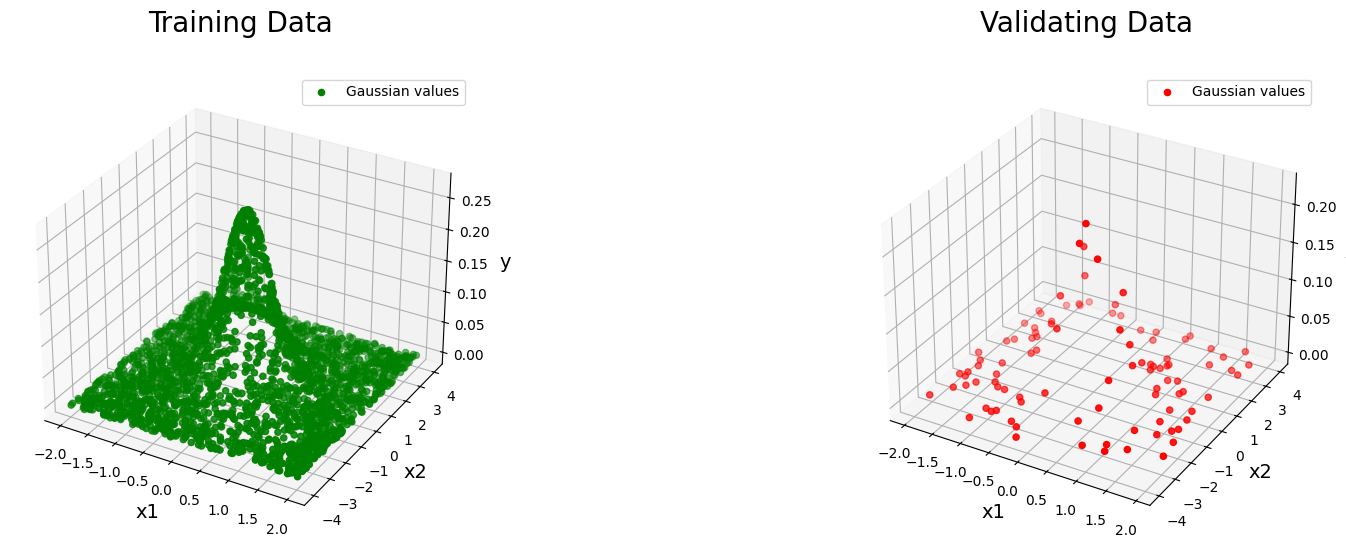

In [19]:
x_expNode_train, y_expNode_train = x_train[:best_sample_size], y_train[:best_sample_size]
x_expNode_valid, y_expNode_valid = x_valid, y_valid

print(f"Train: x-shape = {x_expNode_train.shape} y-shape = {y_expNode_train.shape}")
print(f"Valid: x-shape = {x_expNode_valid.shape} y-shape = {y_expNode_valid.shape}")

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1,2,1, projection='3d')
visualize_dataset(x_expNode_train, y_expNode_train, color = "green", title = "Training Data\n", ax = ax1)

ax2 = plt.subplot(1,2,2, projection='3d')
visualize_dataset(x_expNode_valid, y_expNode_valid, color = "red", title = "Validating Data\n", ax = ax2)

# Model

In [20]:
expNode = build_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer (Dense)             │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

# Training

In [21]:
def train_model(train_id, x_local_train, y_local_train, x_local_valid, y_local_valid, n_hidden = 10, nb_epochs = best_epoch):

    K.clear_session()
    expNode_model = build_model(n_hidden)

    # OPTIMIZATION
    expNode_model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01), metrics=['mean_squared_error'])

    # CALLBACKS
    callbacks = []

    # + ModelCheckPoint
    save_dir = f"./data/model/train_03/{train_id}"
    if os.path.exists(save_dir)==False: os.makedirs(save_dir)
    template_name= "funcApxm_model_01_{epoch:02d}_{val_loss:.3f}_val_acc-{val_mean_squared_error:.3f}.keras"
    if os.path.exists(save_dir) == False: os.makedirs(save_dir)
    modekcheckpoint_callback = ModelCheckpoint(filepath=os.path.join(save_dir, template_name),
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,  # only save weights if set to True
    mode='auto',  # min, max, auto
    save_freq='epoch'  # Replaces 'period', saves every epoch
                                              )
    callbacks.append(modekcheckpoint_callback)

    # + Early Stopping
    # earlystopping_callback = EarlyStopping(monitor='val_loss', patience= 10)
    # callbacks.append(earlystopping_callback)

    # + Visualize logs
    review_logs = {}
    def custom_on_epoch_end(self, epoch, logs, **kwargs):
        review_logs = kwargs["review_logs"]
        if epoch == 0:
            review_logs["epoch"] = [epoch]
            for key in logs.keys(): review_logs[key] = [logs[key]]
        # if
        review_logs["epoch"].append(epoch)
        for key in logs.keys(): review_logs[key].append(logs[key])

        visualize_data = review_logs
        group_view     = [{"x": "epoch", "y": ["loss", "val_loss"],
                           "title": "Loss at Epoch {epoch}: {val_loss:.6f}\n",
                           "style": "median"},
                          {"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"],
                           "title": "MSE at Epoch {epoch}: {val_mean_squared_error:.6f}\n",
                           "style": None}
                         ]
        fig = visualize_logs(visualize_data, group_view, figsize = (10, 6), is_show = False,
                             save_path = os.path.join(f"./data/model/train_03/{train_id}", "logs.png"))
        plt.close()
        if epoch == 0:
            display.display(fig, display_id=f"logs_{train_id}")
        else:
            display.update_display(fig, display_id=f"logs_{train_id}")
        pass
    # custom_on_epoch_end

    custom_callbacks = LambdaCallback()
    custom_callbacks.on_epoch_end = lambda epoch, logs: custom_on_epoch_end(custom_callbacks, epoch, logs, review_logs = review_logs)
    callbacks.append(custom_callbacks)

    # TRAINING
    batch_size = 128
    epochs = nb_epochs

    starting_time = time.time()
    history = expNode_model.fit(x_local_train, y_local_train,
                        validation_data=(x_local_valid, y_local_valid),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks = callbacks,
                        verbose = 0)
    print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))
    return history
# train_model

Train id: 1, Hidden nodes: 1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer (Dense)             │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

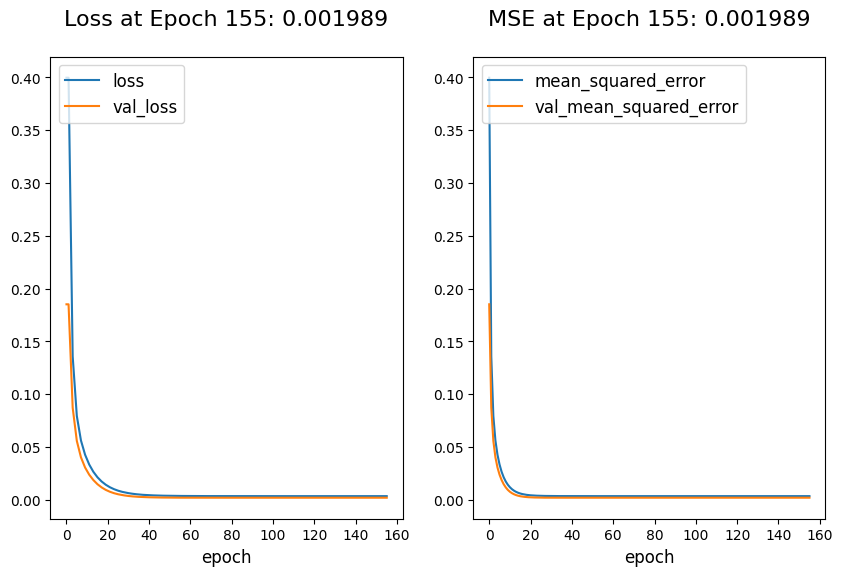

> training time is 0.9461 minutes
Train id: 2, Hidden nodes: 2


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer (Dense)             │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

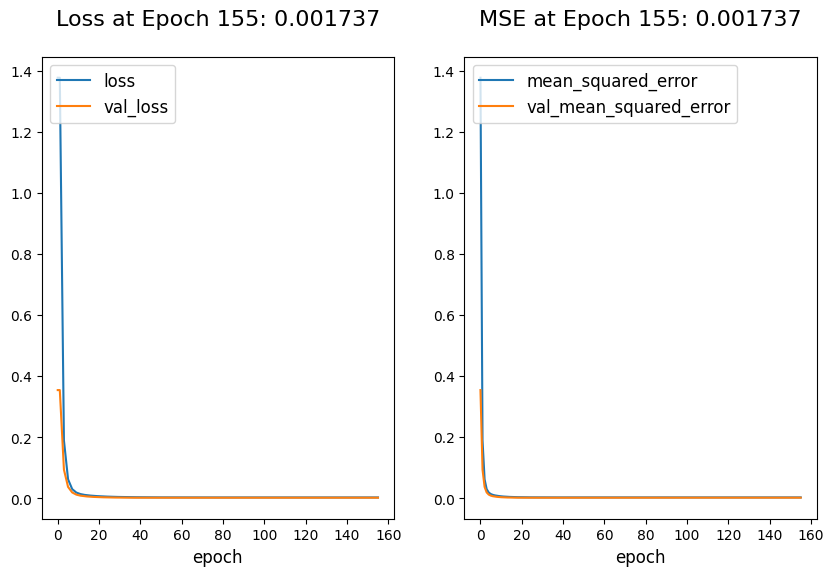

> training time is 0.8703 minutes
Train id: 3, Hidden nodes: 3


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer (Dense)             │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

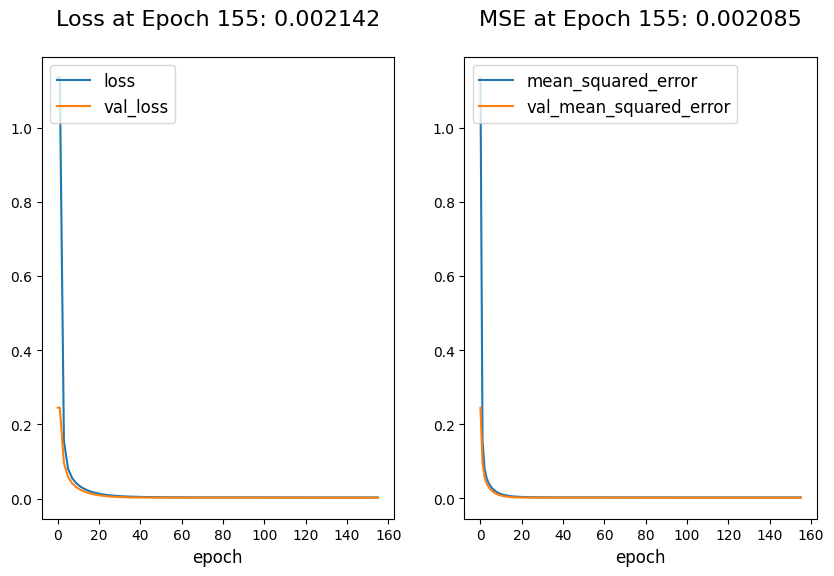

> training time is 0.8479 minutes
Train id: 4, Hidden nodes: 4


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer (Dense)             │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

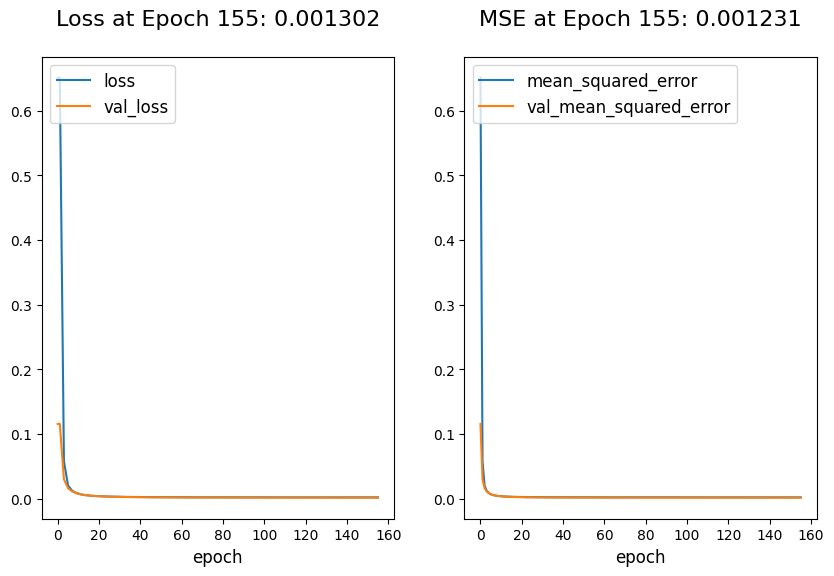

> training time is 0.8799 minutes
Train id: 5, Hidden nodes: 5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer (Dense)             │ (None, 5)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21 (84.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 0 (0.00 B)

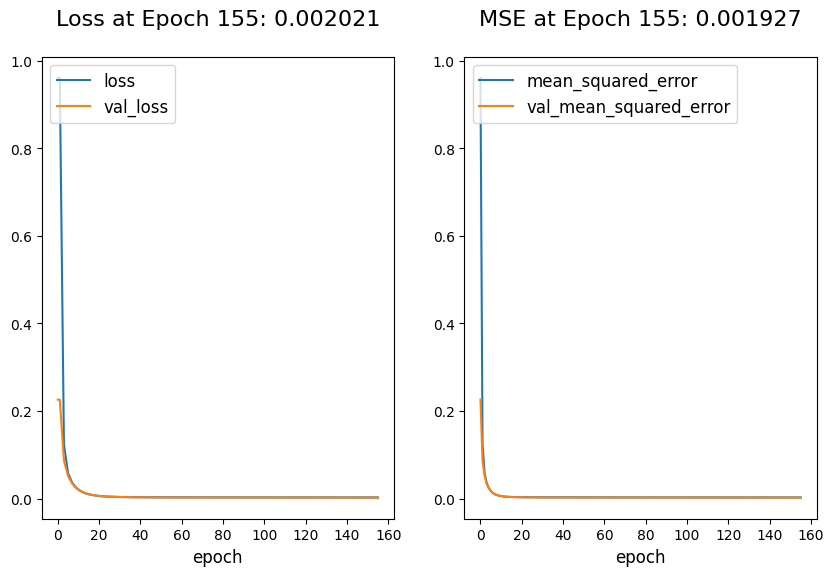

> training time is 0.8483 minutes
Train id: 6, Hidden nodes: 6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer (Dense)             │ (None, 6)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25 (100.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 0 (0.00 B)

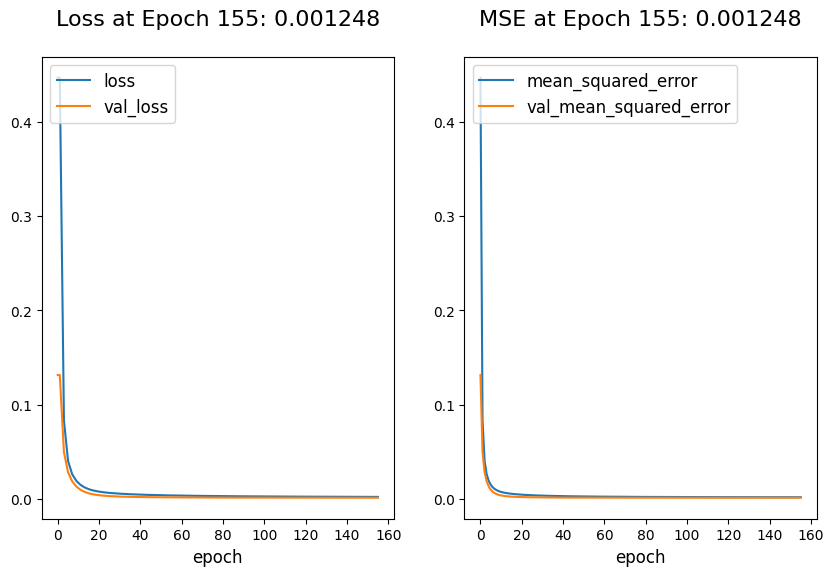

> training time is 0.8224 minutes
Train id: 7, Hidden nodes: 7


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer (Dense)             │ (None, 7)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29 (116.00 B)

 Trainable params: 29 (116.00 B)

 Non-trainable params: 0 (0.00 B)

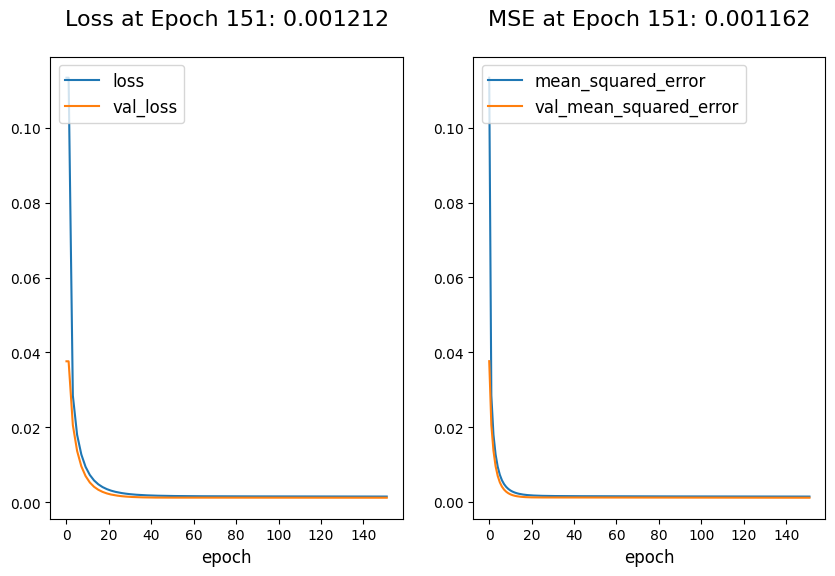

KeyboardInterrupt: 

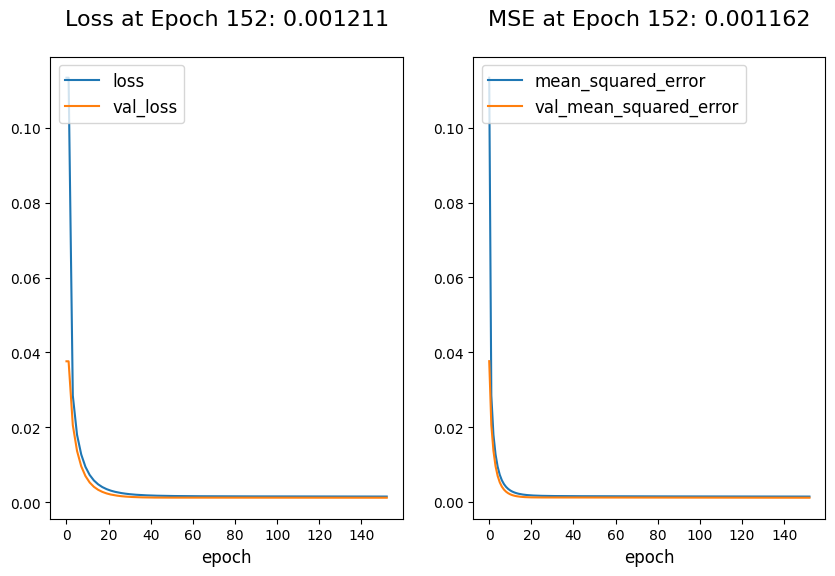

In [22]:
history = []
for i in range(1, 21):  # Số lượng hidden nodes từ 1 đến 20
    print(f"Train id: {i}, Hidden nodes: {i}")
    temp_history = train_model(
        train_id=i,
        x_local_train=x_expNode_train,
        y_local_train=y_expNode_train,
        x_local_valid=x_expNode_valid,
        y_local_valid=y_expNode_valid,
        n_hidden=i,  # Thay đổi số lượng hidden nodes
        nb_epochs=best_epoch
    )
    history.append(temp_history)


# Evaluating

In [ ]:
errors = []
for i in range(len(history)):
    epoch_opt = np.argmin(history[i].history["val_mean_squared_error"])
    error = history[i].history["val_mean_squared_error"][epoch_opt]
    errors.append(error)
# for
hiddens = list(range(1, 21, 1))

In [ ]:
vt_min = np.argmin(np.array(errors))
print(f"Min Error at n_hidden={hiddens[vt_min]} with error = {errors[vt_min]}")
best_nhidden_node = hiddens[vt_min]

Min Error at n_hidden=15 with error = 0.001252110698260367


Text(0.5, 1.0, 'Performance against the # of training samples\n')

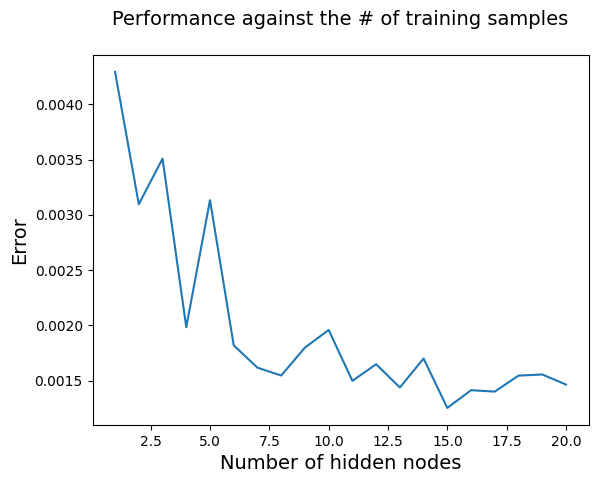

In [ ]:
plt.plot(hiddens, errors)
plt.xlabel("Number of hidden nodes", fontsize = 14)
plt.ylabel("Error", fontsize = 14)
plt.title("Performance against the # of training samples\n", fontsize = 14)

# Report

In [ ]:
# Hiển thị chi tiết kết quả MSE và số nút ẩn
print("\nDetailed Report:")
print(f"{'Hidden Nodes':<15}{'Validation MSE':<15}")
print("-" * 30)
for i, mse in enumerate(errors):
    print(f"{hiddens[i]:<15}{mse:<15.6f}")

# Tóm tắt kết quả tốt nhất
print("\nSummary:")
print(f"The optimal number of hidden nodes is {hiddens[vt_min]} with the smallest validation MSE = {errors[vt_min]:.6f}.")

# Xuất kết quả ra file CSV
optimal_result = {"Hidden Nodes": hiddens, "Validation MSE": errors}
df_result = pd.DataFrame(optimal_result)
df_result.to_csv("./data/optimal_hidden_nodes.csv", index=False)

print("\nResults have been saved to './data/optimal_hidden_nodes.csv'")



Detailed Report:
Hidden Nodes   Validation MSE 
------------------------------
1              0.004293       
2              0.003095       
3              0.003508       
4              0.001982       
5              0.003133       
6              0.001818       
7              0.001616       
8              0.001545       
9              0.001798       
10             0.001957       
11             0.001498       
12             0.001647       
13             0.001437       
14             0.001699       
15             0.001252       
16             0.001412       
17             0.001400       
18             0.001545       
19             0.001555       
20             0.001464       

Summary:
The optimal number of hidden nodes is 15 with the smallest validation MSE = 0.001252.

Results have been saved to './data/optimal_hidden_nodes.csv'


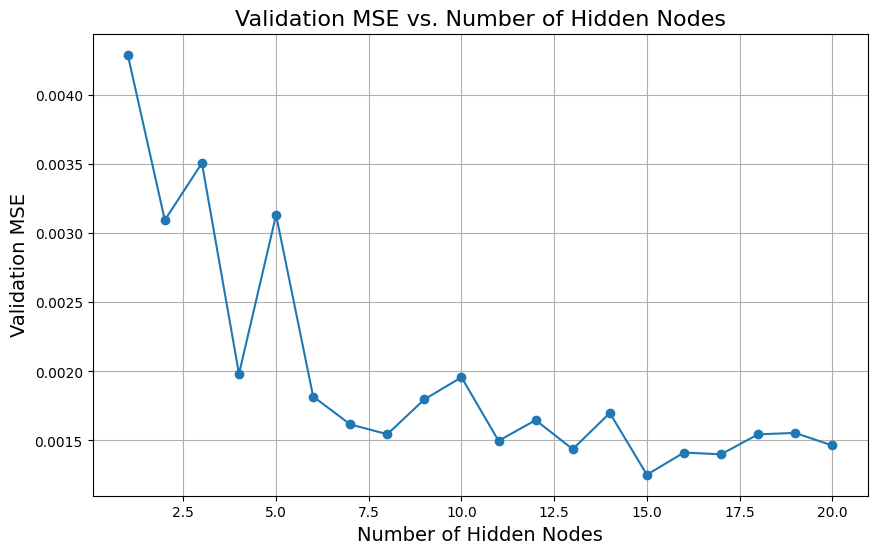

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(hiddens, errors, marker='o')
plt.xlabel("Number of Hidden Nodes", fontsize=14)
plt.ylabel("Validation MSE", fontsize=14)
plt.title("Validation MSE vs. Number of Hidden Nodes", fontsize=16)
plt.grid(True)
plt.show()


In [ ]:
import json

def report_best_size(history, vt_min):
    # Find the model and local epoch corresponding to the optimal global epoch
    val_losses = []
    model_indices = []
    
    for model_idx, hist_obj in enumerate(history):
        val_losses.extend(hist_obj.history["val_loss"])
        model_indices.extend([model_idx] * len(hist_obj.history["val_loss"]))

    best_val_loss = val_losses[vt_min]
    best_model_idx = model_indices[vt_min]

    # Retrieve corresponding `val_mean_squared_error`
    best_val_mse = history[best_model_idx].history["val_mean_squared_error"][
        vt_min - sum(len(history[i].history["val_loss"]) for i in range(best_model_idx))
    ]

    # Generate report
    report = (
        f"=== Báo cáo Kết Quả ===\n"
        f"Model tốt nhất: {best_model_idx}\n"
        f"Số lượng Node tốt nhất (toàn cục): {vt_min + 1}\n"
        f"Validation Loss (MSE): {best_val_loss:.6f}\n"
        f"Validation MSE: {best_val_mse:.6f}\n"
        f"=======================\n"
    )
    
    # Print the report
    print(report)

    # Save to a JSON file
    with open('best_nhidden_node.json', 'w') as f:
        json.dump({"best_nhidden_node": int(vt_min + 1)}, f)

# Call the function
report_best_size(history, vt_min)


=== Báo cáo Kết Quả ===
Model tốt nhất: 0
Số lượng Node tốt nhất (toàn cục): 15
Validation Loss (MSE): 0.009974
Validation MSE: 0.009974

